In [1]:
import importlib
import numpy as np
import scipy as sp
from scipy import integrate
from scipy.interpolate import interp1d
from scipy import signal
import pickle
import matplotlib
import matplotlib.pyplot as plt
# provide sample waveform model
import waveform
# routines for binning, summary data, etc.
import binning

/home/ldai/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
# number of detectors (Livingston and Hanford)
ndtct = 2

# 2048 seconds of strain data at sampling rate of 4096 Hz
n_sample = 2**23
T = 2048.0
n_conv = 20

# we cheat here by loading pre-computed data
_, LFT, psd_L = pickle.load(open('GW170817_L1_f_LFT_psd_taper.pckl','rb'), encoding='latin1')
_, HFT, psd_H = pickle.load(open('GW170817_H1_f_HFT_psd_taper.pckl','rb'), encoding='latin1')

t = np.linspace(0, T, n_sample+1)[:-1]
f = np.linspace(0, 1.0/T*n_sample/2.0, n_sample//2+1)

psd = [psd_L, psd_H]
sFT = [LFT, HFT]

In [3]:
MC = 1.1975                                      # detector frame chirp mass [Msun]
ETA = 0.248                                      # symmetric mass ratio m1*m2/(m1 + m2)**2
DELTA = np.sqrt(1.0 - 4.0*ETA)                   # asymmetric mass ratio (m1 - m2)/(m1 + m2)
M = MC/ETA**0.6                                  # total mass [Msun]
M1 = 0.5*M*(1.0 + DELTA)                        # primary mass [Msun]
M2 = 0.5*M*(1.0 - DELTA)                        # second mass [Msun]
S1Z = 0.0                                        # aligned spin component for the primary
S2Z = 0.0                                        # aligned spin component for the secondary
CHIA = 0.5*(S1Z - S2Z)
CHIS = 0.5*(S1Z + S2Z)
CHIEFF = CHIS + DELTA*CHIA
LAM = 0.0                                      # reduced tidal deformation parameter
TC1 = -205.5556                                  # merger time (L1)
TC2 = -205.5521                                  # merger time (H1)

# allowed bounds for parameters
# change or further refine if desired
Mc_bounds = [1.1973, 1.1979]
eta_bounds = [0.2, 0.24999]
chieff_bounds = [-0.2, 0.2]
chia_bounds = [-0.999, 0.999]
Lam_bounds = [0.0, 1000.0]
dtc_bounds = [-0.005, 0.005]
par_bounds = [Mc_bounds, eta_bounds, chieff_bounds, chia_bounds, Lam_bounds] + [dtc_bounds for k in range(ndtct)]

# fiducial waveforms sampled at full frequency resolution
# slice to the right merger time
h0_L = waveform.hf3hPN(f, M, ETA, s1z=S1Z, s2z=S2Z, Lam=LAM)
h0_H = waveform.hf3hPN(f, M, ETA, s1z=S1Z, s2z=S2Z, Lam=LAM)
# these are NOT shifted to the right merger times
h0_0 = [h0_L, h0_H]
# these are shifted to the right merger times
h0 = [h0_L*np.exp(-2.0j*np.pi*f*TC1), h0_H*np.exp(-2.0j*np.pi*f*TC2)]

# prepare frequency binning
# range of frequency to be used in the computation of likelihood [f_lo, f_hi] [Hz]
f_lo = 23.0
f_hi = 1000.0

Nbin, fbin, fbin_ind = binning.setup_bins(f_full=f, f_lo=f_lo, f_hi=f_hi, chi=1.0, eps=0.5)

In [4]:
sdat = binning.compute_sdat(f, fbin, fbin_ind, ndtct, psd, sFT, h0)

In [5]:
par_bf = waveform.get_best_fit(sdat, par_bounds, h0_0, fbin, fbin_ind, ndtct, atol=1e-10, verbose=True)

log-likelihood =  573.9051307531761
Mc_bf = 1.197594288005246
eta_bf = 0.2381897358241515
chieff_bf = 0.026890596953222677
chia_bf = -0.025826969594371654
Lam_bf = 307.1332956519385
dtcbf = [-0.00055728 -0.00054253]


In [7]:
waveform.lnlike([MC, ETA, CHIEFF, CHIA, LAM, 0.0, 0.0], sdat, h0_0, fbin, fbin_ind, ndtct),  \
waveform.lnlike(par_bf, sdat, h0_0, fbin, fbin_ind, ndtct)

(-499.7074729942443, -573.9051307531761)

In [96]:
print(newpar)
print(par_bf)
print(MC, ETA, CHIEFF, CHIA, LAM, TC1, TC2)

[1.1975462071543357, 0.24952420252939478, -0.0011274256105916756, 0.03440400976041851, 663.3661937118342, -0.00113336, -0.00111735]
[ 1.19754621e+00  2.49524203e-01 -1.12742561e-03  3.44040098e-02
  6.63366194e+02 -1.13336329e-03 -1.11735351e-03]
1.1975462071543357 0.24952420252939478 -0.0011274256105916756 0.03440400976041851 663.3661937118342 -205.55673336328624 -205.55321735350802


In [93]:
newpar = [1.1975462071543357, 0.24952420252939478, -0.0011274256105916756, 0.03440400976041851, 663.3661937118342, \
      0, 0]
waveform.lnlike(par_bf, sdat, h0_0, fbin, fbin_ind, ndtct)

-264.32706526619285

In [8]:
MC = par_bf[0]                                       # detector frame chirp mass [Msun]
ETA = par_bf[1]                                      # symmetric mass ratio m1*m2/(m1 + m2)**2
DELTA = np.sqrt(1.0 - 4.0*ETA)                       # asymmetric mass ratio (m1 - m2)/(m1 + m2)
M = MC/ETA**0.6                                      # total mass [Msun]
M1 = 0.5*M*(1.0 + DELTA)                        # primary mass [Msun]
M2 = 0.5*M*(1.0 - DELTA)                        # second mass [Msun]
CHIEFF = par_bf[2]
CHIA = par_bf[3]
CHIS = CHIEFF - DELTA*CHIA
S1Z = CHIS + CHIA                                        # aligned spin component for the primary
S2Z = CHIS - CHIA                                # aligned spin component for the secondary
LAM = par_bf[4]                                      # reduced tidal deformation parameter
TC1 = -205.5556 + par_bf[5]                                  # merger time (L1)
TC2 = -205.5521 + par_bf[6]

In [59]:
s = sFT[1]
h = h0[1]
p = psd[1]
n = n_sample
fmask = waveform.myHeaviside(f - f_lo)*waveform.myHeaviside(f_hi - f)
cos = 2.0*n*np.fft.irfft(s*np.conjugate(h)*T/p*fmask)
sin = 2.0*n*np.fft.irfft(1.0j*s*np.conjugate(h)*T/p*fmask)
denom = 4.0*np.sum(np.absolute(h)**2*T/p*fmask)
snr2 = (cos**2 + sin**2)/denom

In [9]:
# now update fiducial waveforms
h0_L2 = waveform.hf3hPN(f, M, ETA, s1z=S1Z, s2z=S2Z, Lam=LAM)
h0_H2 = waveform.hf3hPN(f, M, ETA, s1z=S1Z, s2z=S2Z, Lam=LAM)
# these are NOT shifted to the right merger times
h0_02 = [h0_L2, h0_H2]
# these are shifted to the right merger times
h02 = [h0_L2*np.exp(-2.0j*np.pi*f*TC1), h0_H2*np.exp(-2.0j*np.pi*f*TC2)]

In [10]:
sdat2 = binning.compute_sdat(f, fbin, fbin_ind, ndtct, psd, sFT, h02)

In [18]:
waveform.lnlike(par_bf, sdat, h0_0, fbin, fbin_ind, ndtct)

-543.9488849256006

In [12]:
waveform.lnlike(par_bf, sdat, h0_0, fbin, fbin_ind, ndtct)

-573.9051307531761

In [11]:
waveform.lnlike([MC, ETA, CHIEFF, CHIA, LAM, 0.0, 0.0], sdat2, h0_02, fbin, fbin_ind, ndtct)

-573.6642601415634

In [19]:
par_bf, [MC, ETA, CHIEFF, CHIA, LAM, 0.0, 0.0]

(array([1.19763388e+00, 2.29976282e-01, 1.91590296e-03, 7.59794818e-01,
        4.29192742e+02, 3.86908895e-04, 3.99394247e-04]),
 [1.1976338750710913,
  0.22997628195975006,
  0.0019159029606936418,
  0.7597948176830768,
  429.1927415777965,
  0.0,
  0.0])

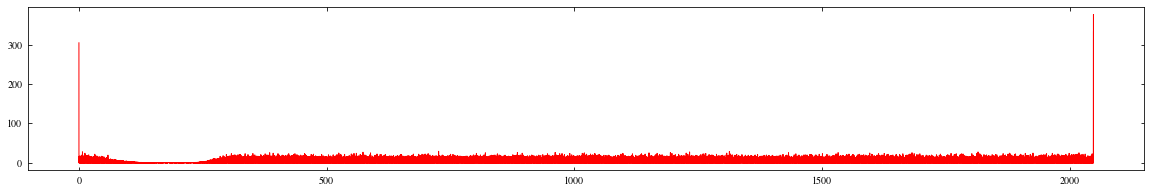

In [75]:
plt.figure(figsize=(20,3))
plt.plot(t, snr2, 'r')
#plt.xlim([2048-205.55-1, 2048-205.55+1])
plt.show()

In [80]:
sdat = binning.compute_sdat(f, fbin, fbin_ind, ndtct, psd, sFT, h0) 

In [81]:
par = [MC, ETA, CHIEFF, CHIA, LAM, 0.0, 0.0]
lnL = waveform.lnlike(par, sdat, h0_0, fbin, fbin_ind, ndtct)

[1.-0.00000000e+00j 1.-3.99811954e-17j 1.+0.00000000e+00j
 1.+0.00000000e+00j 1.-0.00000000e+00j 1.+0.00000000e+00j
 1.+0.00000000e+00j 1.-0.00000000e+00j 1.+0.00000000e+00j
 1.+0.00000000e+00j 1.-0.00000000e+00j 1.+0.00000000e+00j
 1.-0.00000000e+00j 1.-3.94467960e-17j 1.-0.00000000e+00j
 1.-0.00000000e+00j 1.-0.00000000e+00j 1.-0.00000000e+00j
 1.+0.00000000e+00j 1.+0.00000000e+00j 1.+0.00000000e+00j
 1.-0.00000000e+00j 1.+0.00000000e+00j 1.-0.00000000e+00j
 1.+0.00000000e+00j 1.+0.00000000e+00j 1.+0.00000000e+00j
 1.-0.00000000e+00j 1.+0.00000000e+00j 1.+0.00000000e+00j
 1.+0.00000000e+00j 1.+0.00000000e+00j 1.+0.00000000e+00j
 1.-0.00000000e+00j 1.-0.00000000e+00j 1.-1.06169883e-17j
 1.+0.00000000e+00j 1.-0.00000000e+00j 1.+0.00000000e+00j
 1.-0.00000000e+00j 1.-5.09826183e-17j 1.-0.00000000e+00j
 1.-0.00000000e+00j 1.+8.18947961e-18j 1.+0.00000000e+00j
 1.-5.91172264e-17j 1.-0.00000000e+00j 1.-0.00000000e+00j
 1.-0.00000000e+00j 1.+3.92616681e-17j 1.+0.00000000e+00j
 1.+0.00000000

In [82]:
lnL

-499.7074729942443

In [71]:
importlib.reload(binning)

<module 'binning' from '/home/ldai/GWDiffraction/public_code/binning.py'>

In [69]:
ff = fbin[10]
ii = fbin_ind[10]
waveform.hf3hPN(ff, M, ETA, s1z=S1Z, s2z=S2Z, Lam=LAM)/h0[0]*np.exp(-2.0j*np.pi*ff*TC1)

(-1.3438092788228324e-21+4.60485043005599e-22j)

In [67]:
f[fbin_ind[10]], fbin[10]

(35.5556640625, 35.55587903449494)